In [78]:
from functools import partial

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.preprocessing import StandardScaler

from plotnine import (
    ggplot,
    aes,
    geom_bar,
    coord_flip,
    facet_wrap,
    theme,
    theme_bw,
    element_blank,
)

In [24]:
df = pd.read_csv("../data/prepared_data.csv", index_col="SEQN").rename(
    {"any_caffeine.1": "any_caffeine_log"}, axis=1
)
df.head()

,knn_impute__bmi_total,knn_impute__demo_age,knn_impute__activity_sed_min,simple_impute__alcohol_nmbr_drinks,simple_impute__poverty_num,zero_impute__activity_vig_min,zero_impute__activity_mod_min,zero_impute__smoking_cigs_pd,static_impute__occ_hours_worked,passthrough__any_caffeine,passthrough__is_male,passthrough__any_caffeine_log,one_hot__demo_race_str_asian_non_hisp,one_hot__demo_race_str_black,one_hot__demo_race_str_hispanic,one_hot__demo_race_str_other_or_multi,kidney_had_stones,kidney_passed_stone,kidney_weak_failing
SEQN,,,,,,,,,,,,,,,,,,,
109266,37.80,29.0,480.0,1.0,5.00,60.0,30.0,0.0,40.0,25.0,False,3.258097,1.0,0.0,0.0,0.0,False,False,False
109267,22.68,21.0,540.0,2.0,5.00,90.0,0.0,0.0,40.0,0.0,False,0.000000,0.0,0.0,1.0,0.0,False,False,False
109268,21.94,18.0,540.0,2.0,1.19,0.0,0.0,0.0,40.0,0.0,False,0.000000,0.0,0.0,0.0,0.0,False,False,False
109271,29.70,49.0,60.0,2.0,1.20,0.0,0.0,20.0,40.0,2087.5,True,7.644201,0.0,0.0,0.0,0.0,False,False,False
109273,21.90,36.0,180.0,2.0,0.53,0.0,120.0,15.0,28.0,21.5,True,3.113515,0.0,0.0,0.0,0.0,False,False,False


In [20]:
# Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

rfc = RandomForestClassifier(
    n_estimators=1000, max_features="sqrt", random_state=0, oob_score=True, n_jobs=8
)
# print(df)
train_data_X = df.loc[
    :,
    [
        "knn_impute__bmi_total",
        "knn_impute__demo_age",
        "knn_impute__activity_sed_min",
        "simple_impute__alcohol_nmbr_drinks",
        "simple_impute__poverty_num",
        "zero_impute__activity_vig_min",
        # "zero_impute__activity_mod_min",
        "zero_impute__smoking_cigs_pd",
        "static_impute__occ_hours_worked",
        # "passthrough__any_caffeine",
        "passthrough__is_male",
        "passthrough__any_caffeine_log",
        # "one_hot__demo_race_str_asian_non_hisp",
        "one_hot__demo_race_str_black",
        "one_hot__demo_race_str_hispanic",
        # "one_hot__demo_race_str_other_or_multi",
        "kidney_had_stones",
        # "kidney_passed_stone",
        # "kidney_weak_failing"
    ],
]

column_map = {
    "knn_impute__bmi_total": "BMI",
    "knn_impute__demo_age": "Age",
    "knn_impute__activity_sed_min": "Minutes of sedentary activity",
    "simple_impute__alcohol_nmbr_drinks": "Alcoholic drinks per week",
    "simple_impute__poverty_num": "Poverty",
    "zero_impute__activity_vig_min": "Minutes of vigorous activity",
    # "zero_impute__activity_mod_min":"Minutes of moderate activity",
    "zero_impute__smoking_cigs_pd": "Cigarettes per day",
    "static_impute__occ_hours_worked": "Hours worked per week",
    # "passthrough__any_caffeine",
    "passthrough__is_male": "Is male",
    "passthrough__any_caffeine_log": "log(any caffeine)",
    # "one_hot__demo_race_str_asian_non_hisp":"Is asian",
    "one_hot__demo_race_str_black": "Is black",
    "one_hot__demo_race_str_hispanic": "Is hispanic",
    # "one_hot__demo_race_str_mexican_american":"Is mexican american",
    # "one_hot__demo_race_str_other_or_multi":"Is other or multiple races",
    "kidney_had_stones": "kidney_had_stones",
}

train_data_X = train_data_X.rename(column_map, axis=1)
train_data_full = train_data_X.copy()
train_data_Y = train_data_X.pop("kidney_had_stones")


cv_data = cross_validate(
    rfc,
    train_data_X,
    train_data_Y,
    cv=10,
    scoring=["accuracy", "roc_auc"],
    return_train_score=True,
)

print(cv_data)
print("")
print("cv accuracy: " + str(np.mean(cv_data["test_accuracy"])))
print("cv auc score: " + str(np.mean(cv_data["test_roc_auc"])))

rfc.fit(train_data_X, train_data_Y)

importances = rfc.feature_importances_
forest_importances = pd.Series(importances, index=rfc.feature_names_in_)

{'fit_time': array([2.54848099, 1.63796997, 1.64273787, 1.68291569, 1.66385221,
       1.6133368 , 1.58927584, 1.63778305, 1.73846793, 1.63712978]), 'score_time': array([0.15150905, 0.15694594, 0.1474781 , 0.22981405, 0.14492178,
       0.14895511, 0.14974213, 0.1939261 , 0.14489508, 0.14565802]), 'test_accuracy': array([0.91030928, 0.90927835, 0.91030928, 0.90918473, 0.91021672,
       0.91021672, 0.91124871, 0.91021672, 0.91021672, 0.91021672]), 'train_accuracy': array([0.99965608, 0.99965608, 0.99977072, 0.99977075, 0.99977075,
       0.99977075, 0.99965612, 0.99965612, 0.99965612, 0.99977075]), 'test_roc_auc': array([0.62706812, 0.67359186, 0.61717499, 0.61378361, 0.58677474,
       0.60902315, 0.66304749, 0.61141736, 0.61193865, 0.67512446]), 'train_roc_auc': array([0.99999919, 0.99999919, 0.9999996 , 0.99999968, 0.9999996 ,
       0.9999996 , 0.99999919, 0.99999927, 0.99999919, 0.99999968])}

cv accuracy: 0.9101413935080271
cv auc score: 0.6288944418789163


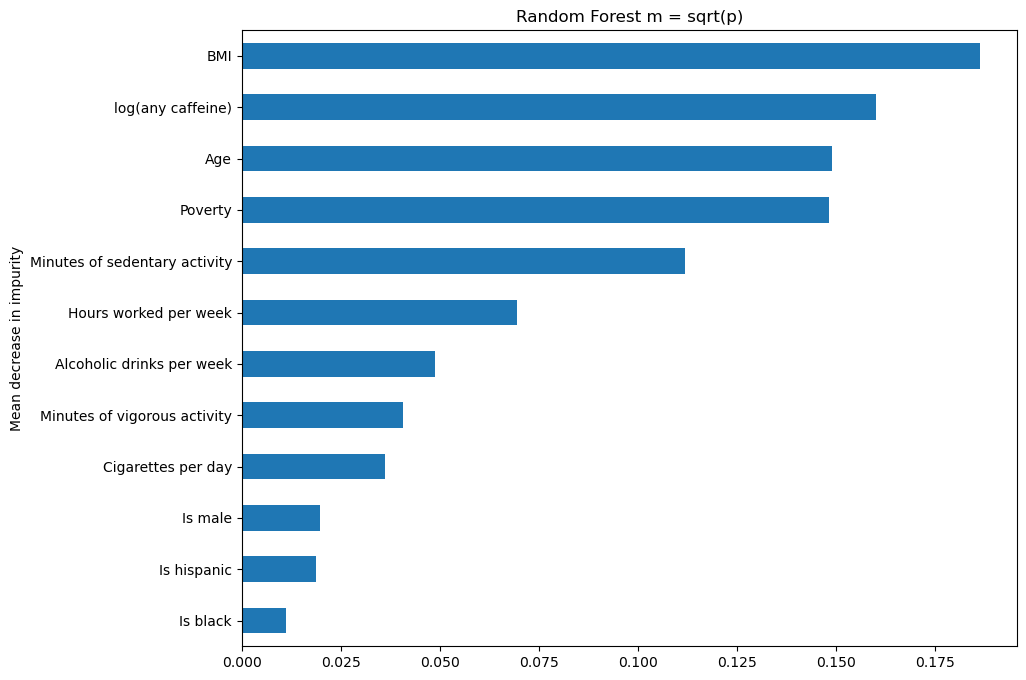

In [15]:
plt.figure(figsize=(10, 8))
forest_importances.sort_values(ascending=True).plot.barh()
plt.title("Random Forest m = sqrt(p)")
plt.ylabel("Mean decrease in impurity")
plt.show()

In [16]:
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

forest_importances

BMI                              0.186374
Age                              0.149118
Minutes of sedentary activity    0.111790
Alcoholic drinks per week        0.048775
Poverty                          0.148245
Minutes of vigorous activity     0.040698
Cigarettes per day               0.036039
Hours worked per week            0.069442
Is male                          0.019630
log(any caffeine)                0.160048
Is black                         0.011193
Is hispanic                      0.018646
dtype: float64

In [25]:
train_data_full_X = train_data_full.copy()
train_data_full_X = train_data_full_X.reset_index()
train_data_full_X = train_data_full_X.drop("SEQN", axis=1)

In [26]:
kf = KFold(random_state=3, n_splits=5, shuffle=True)
result = []
perm_forest_importances = pd.DataFrame([])
train_data_full_Y = train_data_full_X.pop("kidney_had_stones")
rfc_noparallel = RandomForestClassifier(
    n_estimators=1000, max_features="sqrt", random_state=0, oob_score=True
)
for i, (train_index, test_index) in enumerate(kf.split(train_data_full)):
    rfc_noparallel.fit(
        train_data_full_X.loc[train_index, :], train_data_full_Y[train_index]
    )
    result.append(
        permutation_importance(
            rfc_noparallel,
            train_data_full_X.loc[test_index, :],
            train_data_full_Y[test_index],
            n_repeats=10,
            random_state=42,
            n_jobs=8,
        )
    )
    perm_forest_importances[i] = pd.Series(
        result[i].importances_mean, index=rfc_noparallel.feature_names_in_
    )

In [28]:
train_data_full_X.loc[train_index, :]
train_data_full_Y[train_index]

0       False
1       False
2       False
3       False
4       False
        ...  
9685     True
9686    False
9687     True
9688    False
9689     True
Name: kidney_had_stones, Length: 7755, dtype: bool

<Figure size 1000x1200 with 0 Axes>

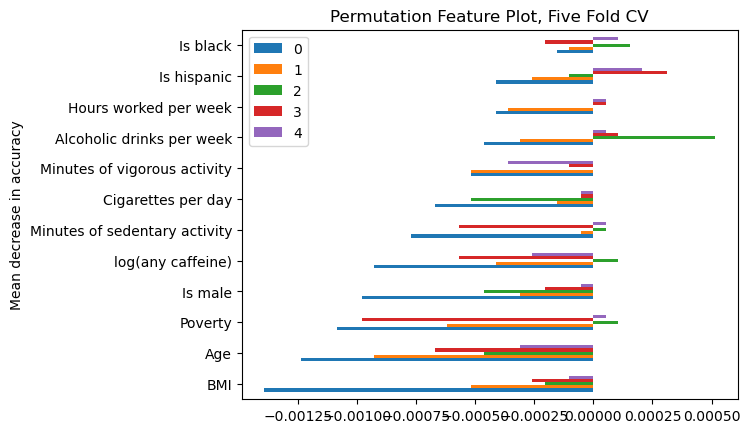

In [30]:
plt.figure(figsize=(10, 12))
perm_forest_importances.sort_values(ascending=True, by=0).plot.barh()
plt.title("Permutation Feature Plot, Five Fold CV")
plt.ylabel("Mean decrease in accuracy")
plt.show()

In [34]:
perm_forest_importances.columns = [f"Fold_{i}" for i in range(5)]

,Fold_0,Fold_1,Fold_2,Fold_3,Fold_4
BMI,-0.001392,-0.000516,-2.062919e-04,-0.000258,-0.000103
Age,-0.001238,-0.000928,-4.641568e-04,-0.000671,-0.000310
Minutes of sedentary activity,-0.000774,-0.000052,5.157298e-05,-0.000568,0.000052
Alcoholic drinks per week,-0.000464,-0.000309,5.157298e-04,0.000103,0.000052
Poverty,-0.001083,-0.000619,1.031460e-04,-0.000980,0.000052
Minutes of vigorous activity,-0.000516,-0.000516,-2.220446e-17,-0.000103,-0.000361
Cigarettes per day,-0.000670,-0.000155,-5.157298e-04,-0.000052,-0.000052
Hours worked per week,-0.000413,-0.000361,0.000000e+00,0.000052,0.000052
Is male,-0.000980,-0.000309,-4.641568e-04,-0.000206,-0.000052
log(any caffeine),-0.000928,-0.000413,1.031460e-04,-0.000568,-0.000258


/Users/mcanearm/miniconda3/envs/ygtbkm/lib/python3.12/site-packages/plotnine/utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/mcanearm/miniconda3/envs/ygtbkm/lib/python3.12/site-packages/plotnine/utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/mcanearm/miniconda3/envs/ygtbkm/lib/python3.12/site-packages/plotnine/geoms/geom.py:289: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


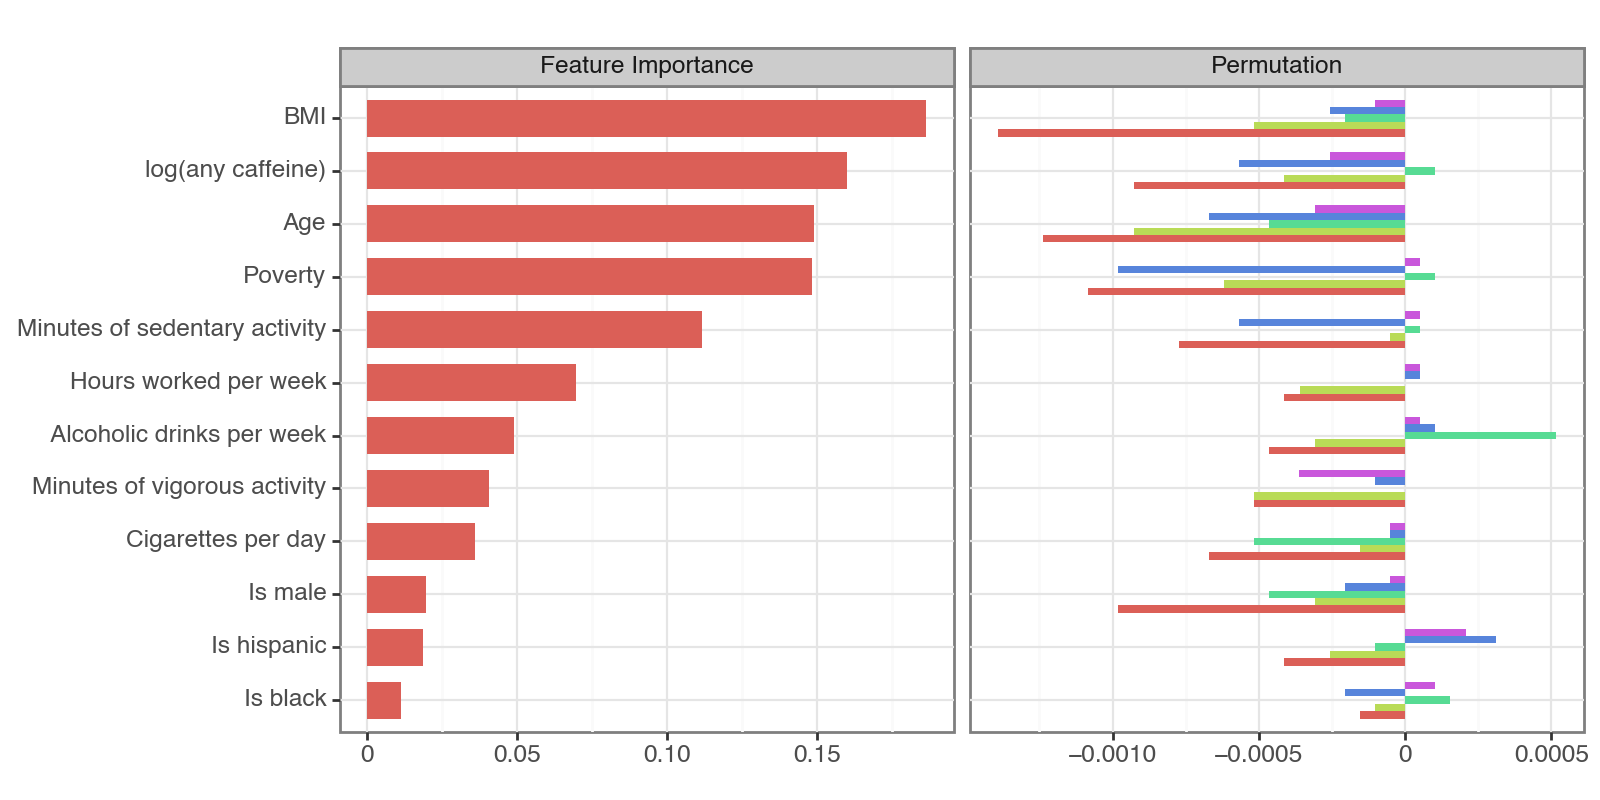

<Figure Size: (800 x 400)>

In [136]:
# perm_forest_importances.assign(method="perm")
importance_df = (
    pd.DataFrame(forest_importances).assign(method="Feature Importance").assign(fold="Fold_0")
)
importance_df.columns = ["importance", "method", "fold"]
importance_df = importance_df.reset_index(names="feature")

perm_forest_df = (
    perm_forest_importances.reset_index(names="feature")
    .assign(method="Permutation")
    .melt(id_vars=["feature", "method"], var_name="fold", value_name="importance")
)

categories = pd.DataFrame(importance_df.sort_values("importance")["feature"]).reset_index(drop=True).reset_index(names="id")
# importance_df["feature"] = pd.Categorical(importance_df["feature"], categories=categories)
# perm_forest_df["feature"] = pd.Categorical(perm_forest_df["feature"], categories=categories)



# perm_forest_df
plot_df = pd.concat([importance_df, perm_forest_df]).merge(categories, left_on="feature", right_on="feature")
# importance_df.merge(perm_forest_df, left_on="feature", right_on="feature")
# 
# plot_df.sort_values(["method", "importance"])


(
    ggplot(data=plot_df, mapping=aes(x="reorder(feature, id)", y="importance", fill="fold"))
    + coord_flip()
    + facet_wrap("~method", scales="free_x")
    + geom_bar(stat="identity", position="dodge", show_legend=False, width=0.7)
    + theme_bw()
    + theme(axis_title_x = element_blank(), axis_title_y=element_blank(), figure_size=(6, 4))
)